In [1279]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, j1, jv, i0, jvp
from scipy.special import jn_zeros
from scipy.integrate import quad
from scipy.integrate import dblquad
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

## Constants and math functions

In [1280]:
H = 12
R = 0.01

z = np.linspace(0, H, 80)
r = np.linspace(0, R, 80)

max_k = 50
max_n = 50

In [1281]:
T_nk_array = np.load("T_nk_array_steel_h12_r0.01.npy")
T_nk_array

array([[ 1.10277362e-04,  5.66276451e-05, -3.34170426e-05, ...,
         9.19803862e-06,  9.40952709e-06,  9.60480826e-06],
       [-2.39211047e-18, -1.22763074e-18,  7.24541174e-19, ...,
        -1.99453994e-19, -2.03906614e-19, -2.08344482e-19],
       [-5.25317887e-05, -2.69742939e-05,  1.59180597e-05, ...,
        -4.38323197e-06, -4.48401465e-06, -4.57707391e-06],
       ...,
       [-2.56949501e-18, -1.31905074e-18,  7.78106489e-19, ...,
        -2.14189655e-19, -2.19147906e-19, -2.23694810e-19],
       [ 1.39015818e-05,  7.13848997e-06, -4.21255772e-06, ...,
         1.15950622e-06,  1.18616649e-06,  1.21078366e-06],
       [ 9.86076855e-19,  5.05729293e-19, -2.98669658e-19, ...,
         8.22289367e-20,  8.41189535e-20,  8.57967813e-20]])

In [1282]:
def find_beta_k_roots(max_k, R=1):
    # Находим первые max_k нулей функции Бесселя первого порядка j1
    j1_zeros = jn_zeros(1, max_k)
    # Вычисляем соответствующие β_k = j1_zero / R
    roots = j1_zeros / R
    return roots

In [1283]:
G = 75
LAMBDA = 120
mu = 0.3
mu_0 = (LAMBDA + G)/G
alpha = 1.2e-5 

def a_k(k):
    return np.pi*(2 * k + 1) / 2

def lambda_n(n, H):
    return (np.pi * n) / H 

beta_k = find_beta_k_roots(max_k, R)

In [1284]:
j0bk = np.empty(max_k)
for k in range(max_k):
    j0bk[k] = j0(beta_k[k])

In [1285]:
ak = np.empty(max_k)
for k in range(0, max_k+1):
    ak[k-1] = a_k(k)

In [1286]:
lambdan = np.empty(max_n)
for k in range(0, max_n+1):
    lambdan[k-1] = lambda_n(k, H)

## Solutions

### Function $T$ of temperature

The solution of the mathematical model of the heat conduction problem
$$
T(r, z)=\sum^\infty_0\frac{I_0(a_kr)}{I_0(a_kR)}f_ksin(a_kz)
$$
Where
$$ 
f_k=\int^H_0f(z)sin(a_kz)dz 
$$

In [1287]:
def f(z):
    return -z**2+H*z

def f_k(k, H):
    integrand = lambda z: f(z) * np.sin(ak[k-1] * z)
    integral = quad(integrand, 0, H)[0]
    return integral

In [1288]:
f_k_array = np.empty(max_k)
for k in range(1, max_k+1):
    result = f_k(k, H)
    f_k_array[k-1] = result 

In [1289]:
def T(r, z):
    sum = np.sum((f_k_array / i0(ak * R)) * i0(ak * r) * np.sin(ak * z))
    return (2 / H) * sum

$$
T_{nk}=\int^R_0J_0(\beta_kr)rdr\int^H_0T(r,z)cos(\lambda_nz)dz \\
\lambda_n=\frac{\pi n}{2},\ \ n=0,1,... \\
\beta_k \text{ - solutions of the equation: } J_0(\beta_kR)=0 
$$

In [1290]:
def T_nk(n, k, T_func, R, H):
    """
    Возвращает двойной интеграл
        ∫_{r=0}^R ∫_{z=0}^H T(r,z) * j0(beta_k[k] * r) * r * cos(lambdan[n] * z) dz dr
    """
    # Функция для dblquad: первый аргумент — z, второй — r
    def integrand(z, r):
        return T_func(r, z) * j0bk[k-1] * r * np.cos(lambdan[n-1] * z)

    # dblquad ожидает порядок: dblquad(func, r_min, r_max, z_min_fun, z_max_fun)
    result, error = dblquad(integrand,
                            0,     # r от 0
                            R,     # до R
                            lambda r: 0,  # для каждого r, z от 0
                            lambda r: H)  # до H
    return result

In [1291]:
# T_nk_array = np.empty((max_n, max_k))
# H_array = [6, 12]
# R_array = [0.005, 0.01]
# for h in H_array:
#     for r in R_array:
#         beta_k = find_beta_k_roots(max_k, r)
#         lambdan = np.empty(max_n)
#         for k in range(0, max_n+1):
#             lambdan[k-1] = lambda_n(k, h)
#         f_k_array = np.empty(max_k)
#         for k in range(1, max_k+1):
#             result = f_k(k, h)
#             f_k_array[k-1] = result 
#         for n in range(1, max_n+1):
#             for k in range(1, max_k+1):
#                 result = T_nk(n, k, T, r, h)
#                 print(n, k, result)
#                 T_nk_array[n-1, k-1] = result
#         with open(f"T_nk_array_steel_h{h}_r{r}.npy", 'wb') as file:
#             np.save(file, T_nk_array)

### Functions $u(r, z)$ and $w(r, z)$

$$
u(r,z)=\frac{4\mu_0\alpha}{HR^2}
\left(\sum_{k=1}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)}  \frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}T_{0k}
+2\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} 
cos(\lambda_nz)\right)T_{nk}
$$

In [1292]:
def u(r, z):
    sum_u = 0.0
    for k in range(1, max_k + 1):
        sum_u += (1 / beta_k[k-1]) * (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * T_nk_array[0, k-1]
    for n in range(1, max_n + 1):
        for k in range(1, max_k + 1):
            sum_u += 2 * (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (beta_k[k-1] / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u

$$
w(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{0k}r)}{J_0^2(\beta_{0k}R)}
\sum_{n=1}^\infty \frac{\lambda_n}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)T_{nk}
$$

In [1293]:
def w(r, z):
    sum_w = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w += np.sin(lambdan[n-1] * z) * (j0(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (lambdan[n-1] / (beta_k[k-1]**2 + lambdan[n-1]**2)) * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w

### Partial derivative $u(r, z)$

$$
\frac{\partial u}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda_n^2}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)T_{nk}
$$

In [1294]:
def partial_u_z(r, z):
    sum_u_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_u_z += j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2 * (lambdan[n-1] ** 2 / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.sin(lambdan[n-1] * z)  * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_u_z

In [1295]:
def partial_u_r(r, z):
    sum_u = 0.0
    for k in range(1, max_k + 1):
        sum_u += (1 / beta_k[k-1]) * (jvp(beta_k[k-1] * r, 1) / j0(beta_k[k-1] * R)**2) * T_nk_array[0, k-1]
    for n in range(1, max_n + 1):
        for k in range(1, max_k + 1):
            sum_u += 2 * (jvp(beta_k[k-1] * r, 1) / j0(beta_k[k-1] * R)**2) * (beta_k[k-1] / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u

### Partial derivative $w(r, z)$

$$
\frac{\partial w}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda^2_n}{\left(\beta^2_k+\lambda^2_n\right)} cos(\lambda_nz)T_{nk}
$$

In [1296]:
def partial_w_z(r, z):
    sum_w_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w_z += j0(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2 * (lambdan[n-1]**2 / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w_z

### Voltages $\Theta(r, z),\  \sigma_r(r, z),\  \sigma_z(r, z)$

In [1297]:
def theta(r, z):
    return 1/r * u(r, z) + partial_u_r(r, z)

In [1298]:
def sigma_r(r, z):
    return 2 * G * (partial_u_r(r, z) + mu/(1-2*mu)*theta(r, z))

In [1299]:
def sigma_z(r, z):
    return 2 * G * (partial_w_z(r, z) + mu/(1-2*mu)*theta(r, z))

In [1300]:
def tau_rz(r, z):
    return G*partial_u_z(r, z)

In [1301]:
def sigma_eq(r, z):
    return np.sqrt(sigma_r(r, z)**2+sigma_z(r, z)**2-sigma_z(r, z)*sigma_r(r, z) + 3*tau_rz(r, z)**2)

## Plot boundary conditions

In [1302]:
def plot2d(x, y, xlim, xlabel="", ylabel="", title="", plot=plt):
    plot.plot(x, y)
    if plot is plt:
        plot.xlim(0, xlim)
        plot.xlabel(xlabel)
        plot.ylabel(ylabel)
        plot.title(title)
    else:
        plot.grid()
        plot.set_xlim(0, xlim)
        plot.set_xlabel(xlabel)
        plot.set_ylabel(ylabel)
        plot.set_title(title)


$$w(r, 0)=0$$
$$\frac{\partial u}{\partial z}|_{z=0}=0$$
$$w(r, H)=0$$
$$\frac{\partial u}{\partial z}|_{z=H}=0$$
$$u(R, z)=0$$

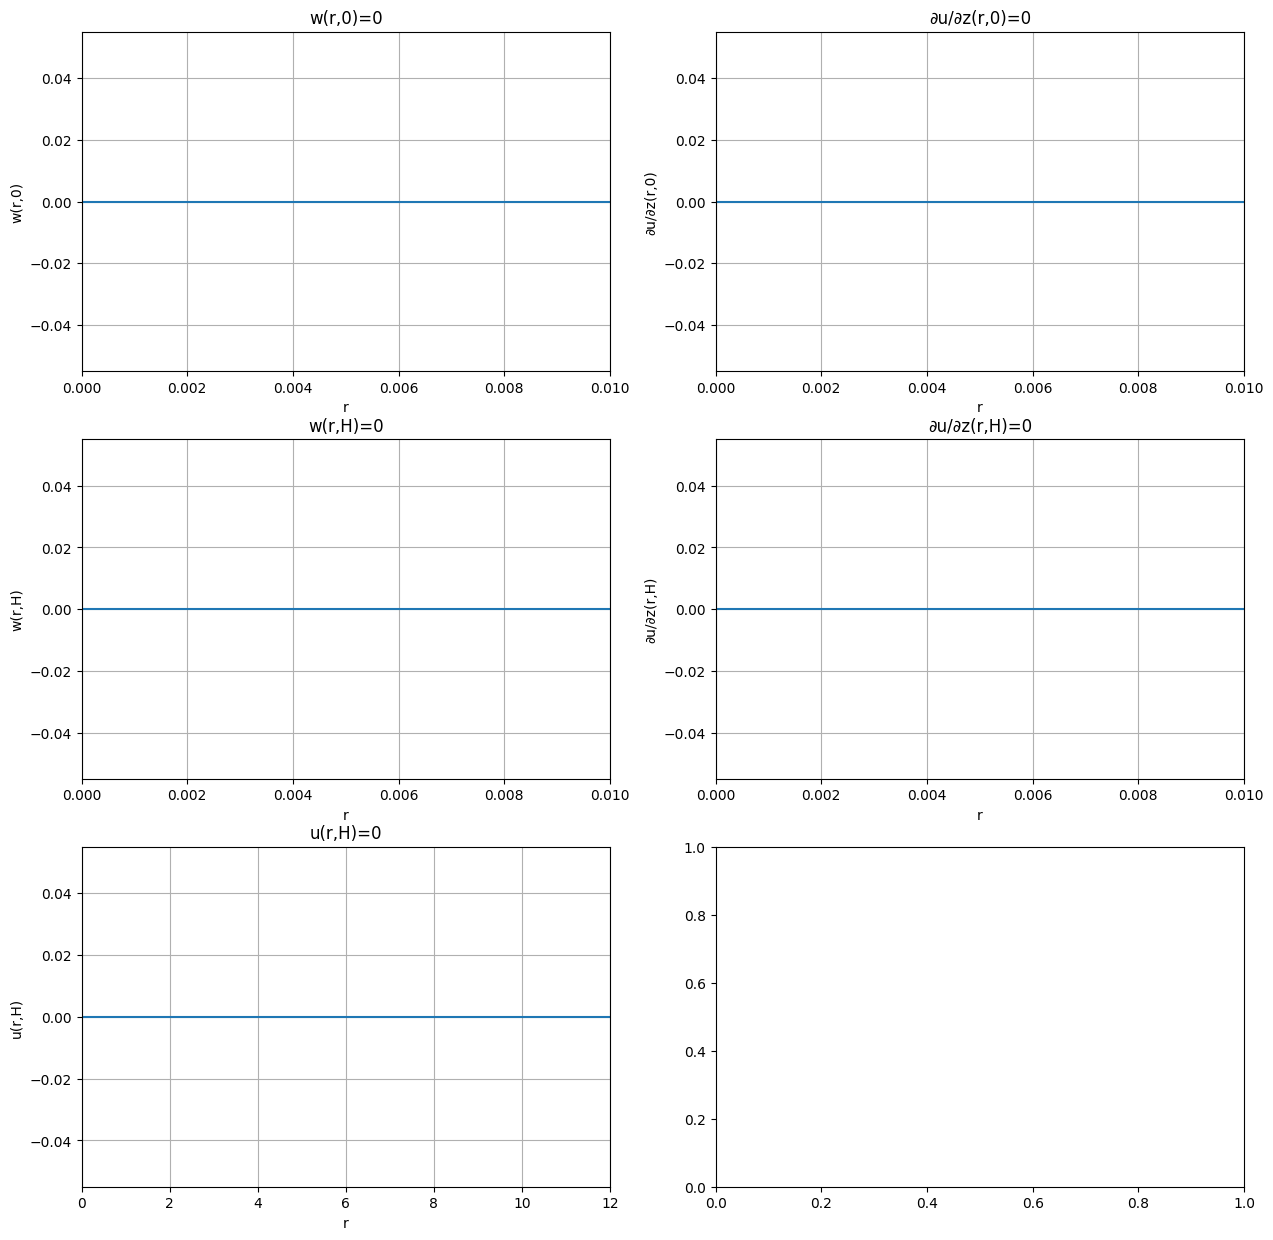

In [1303]:
figure, axis = plt.subplots(3, 2)
figure.set_figheight(15)
figure.set_figwidth(15)

plot2d(r, w(r, 0), R, "r", "w(r,0)", "w(r,0)=0", axis[0, 0])
plot2d(r, partial_u_z(r, 0), R, "r", "∂u/∂z(r,0)", "∂u/∂z(r,0)=0", axis[0, 1])
plot2d(r, np.round(w(r, H), 9), R, "r", "w(r,H)", "w(r,H)=0", axis[1, 0])
plot2d(r, np.round(partial_u_z(r, H), 9), R, "r", "∂u/∂z(r,H)", "∂u/∂z(r,H)=0", axis[1, 1]) 
plot2d(z, np.round(u(R, z), 9), H, "r", "u(r,H)", "u(r,H)=0", axis[2, 0])

## Plot solutions

In [1304]:
def plot3d(r, z, f, rlabel='r', zlabel='z', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(r[0], r[-1])
    ax.set_ylim(z[0], z[-1])
    
    r3d, z3d = np.meshgrid(r, z)
    
    print(np.max(f(r3d, z3d)))

    ax.plot_surface(r3d, z3d, np.round(f(r3d, z3d), 9), cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel(rlabel)
    ax.set_ylabel(zlabel)

1.4369035329691374e-08


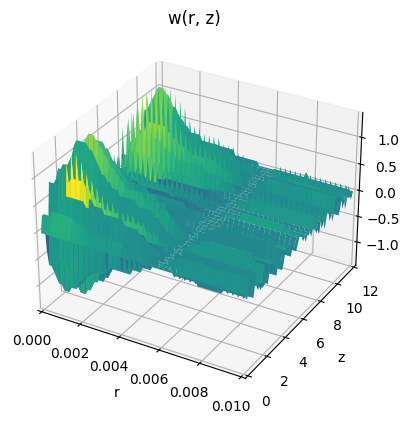

In [1305]:
plot3d(r, z, w, title="w(r, z)")

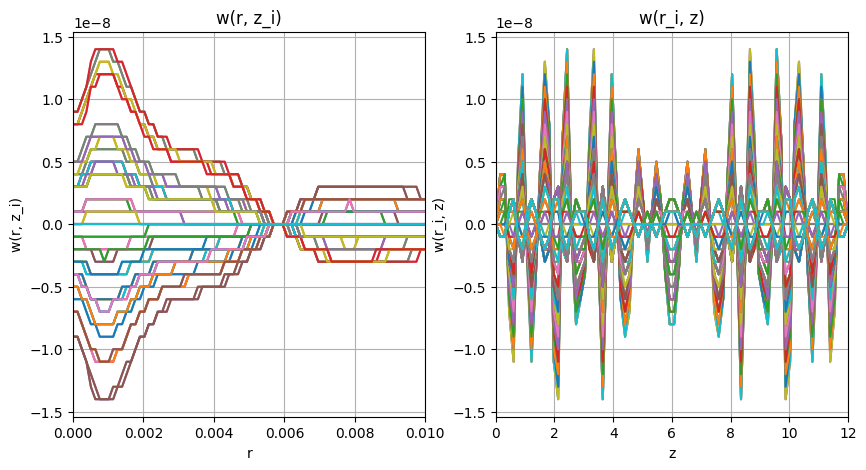

In [1306]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(w(r, i), 9), R, "r", "w(r, z_i)", "w(r, z_i)", plot=axis[0])

for i in r:
    plot2d(z, np.round(w(i, z), 9), H, "z", "w(r_i, z)", "w(r_i, z)", plot=axis[1])

1.4198862420158847e-07


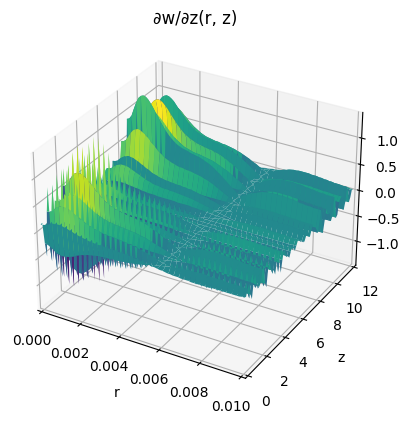

In [1307]:
plot3d(r, z, partial_w_z, title="∂w/∂z(r, z)")

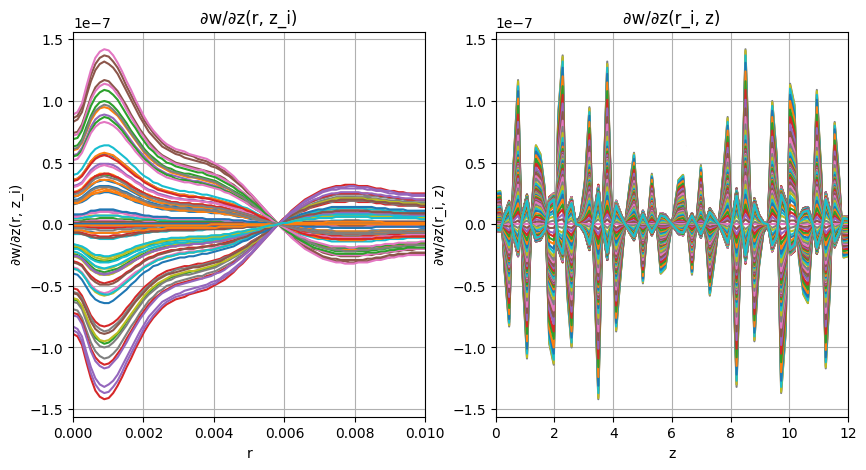

In [1308]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_w_z(r, i), 9), R, "r", "∂w/∂z(r, z_i)", "∂w/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_w_z(i, z), 9), H, "z", "∂w/∂z(r_i, z)", "∂w/∂z(r_i, z)", plot=axis[1])

1.9456886753499177e-06


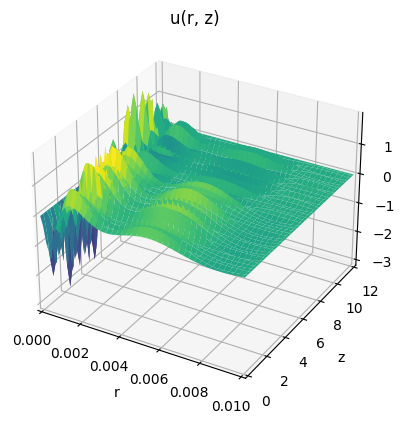

In [1309]:
plot3d(r, z, u, title="u(r, z)")

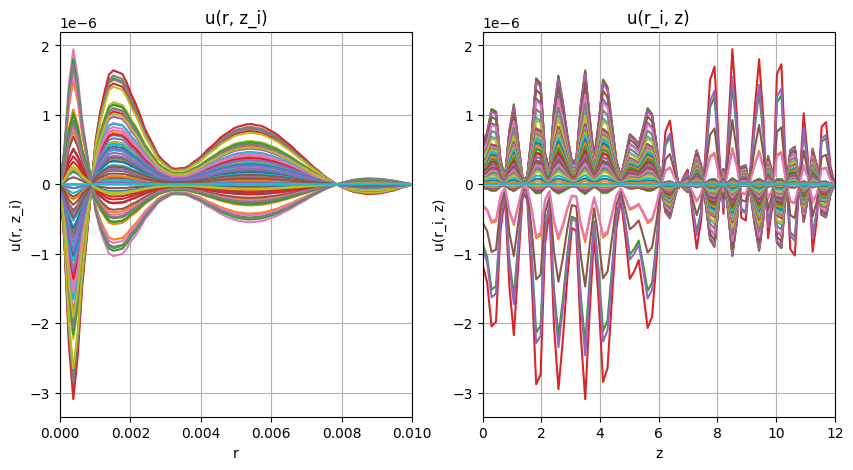

In [1310]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(u(r, i), 9), R, "r", "u(r, z_i)", "u(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(u(i, z), 9), H, "z", "u(r_i, z)", "u(r_i, z)", plot=axis[1])

1.3656599985740423e-06


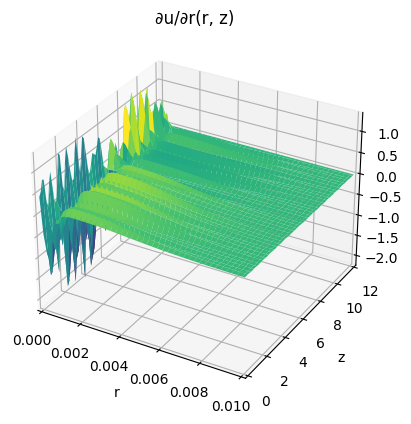

In [1311]:
plot3d(r, z, partial_u_r, title="∂u/∂r(r, z)")

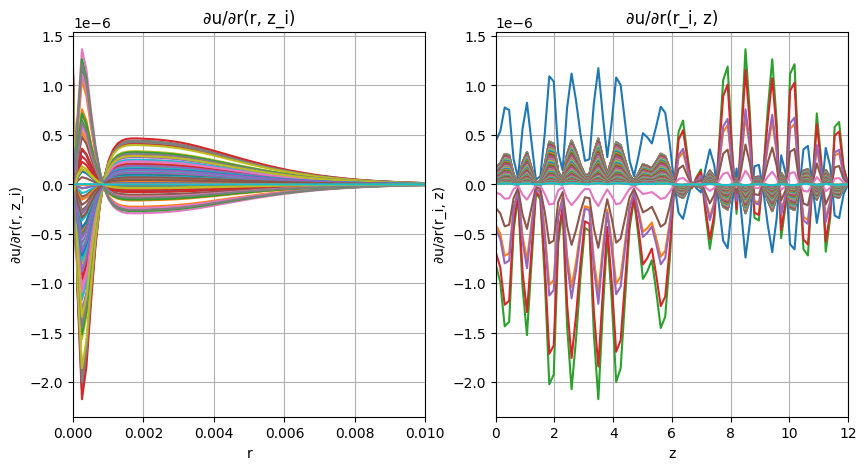

In [1312]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_r(r, i), 9), R, "r", "∂u/∂r(r, z_i)", "∂u/∂r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_r(i, z), 9), H, "z", "∂u/∂r(r_i, z)", "∂u/∂r(r_i, z)", plot=axis[1])

5.823495274751913e-08


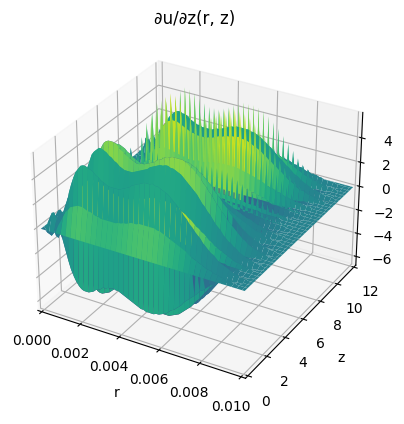

In [1313]:
plot3d(r, z, partial_u_z, title="∂u/∂z(r, z)")

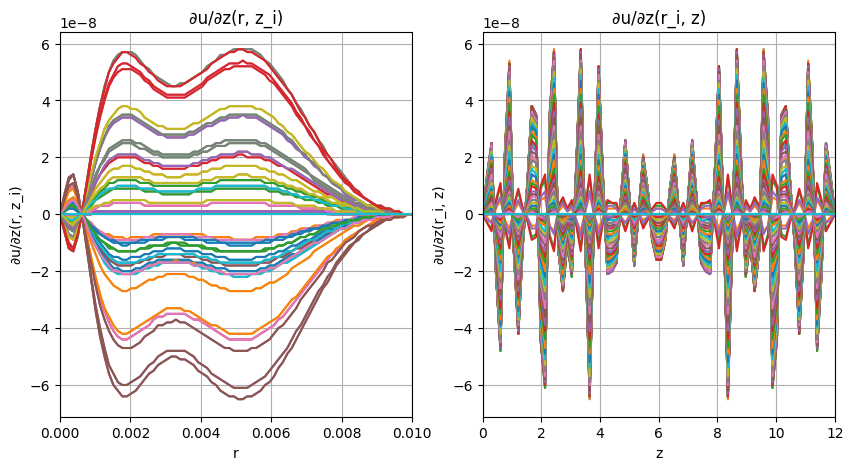

In [1314]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_z(r, i), 9), R, "r", "∂u/∂z(r, z_i)", "∂u/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_z(i, z), 9), H, "z", "∂u/∂z(r_i, z)", "∂u/∂z(r_i, z)", plot=axis[1])

## Plot voltages functions

In [1315]:
r = r[1:]
z = z[1:]

0.0057014497146882625


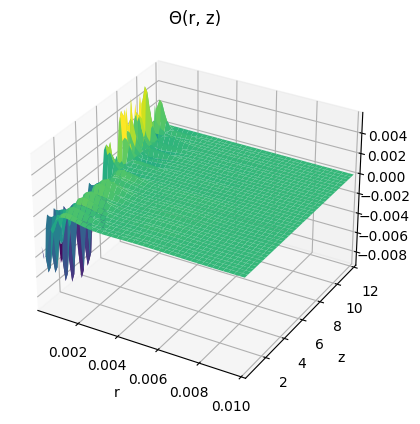

In [1316]:
plot3d(r, z, theta, title="Θ(r, z)")

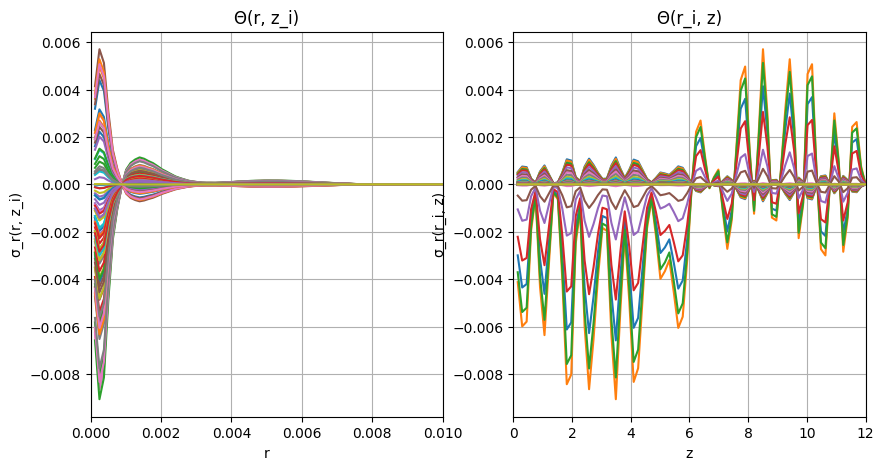

In [1317]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(theta(r, i), 9), R, "r", "σ_r(r, z_i)", "Θ(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(theta(i, z), 9), H, "z", "σ_r(r_i, z)", "Θ(r_i, z)", plot=axis[1])

0.6416179419022155


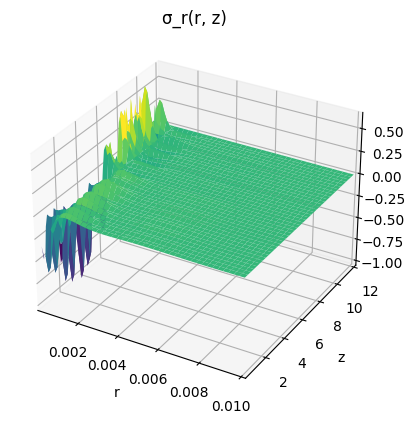

In [1318]:
plot3d(r, z, sigma_r, title="σ_r(r, z)")

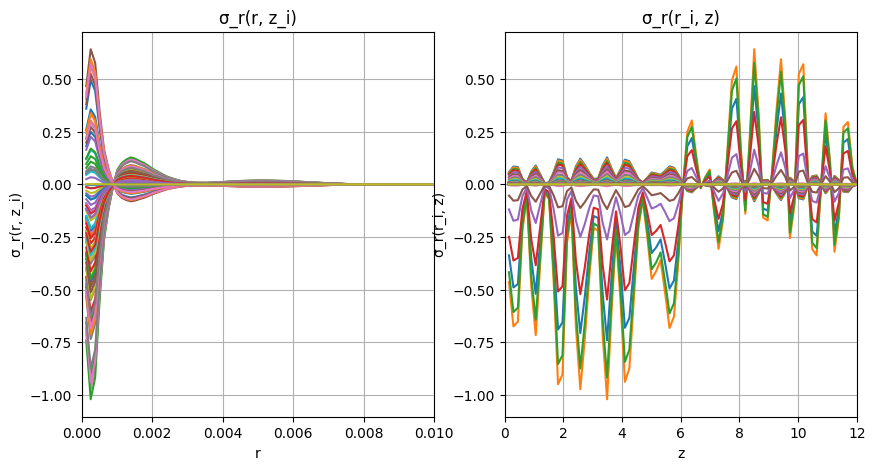

In [1319]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(sigma_r(r, i), 9), R, "r", "σ_r(r, z_i)", "σ_r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_r(i, z), 9), H, "z", "σ_r(r_i, z)", "σ_r(r_i, z)", plot=axis[1])

0.641427863760203


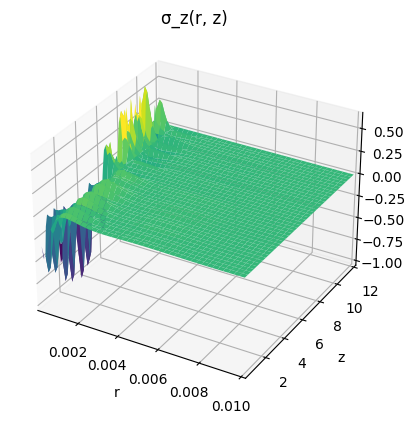

In [1320]:
plot3d(r, z, sigma_z, title="σ_z(r, z)")

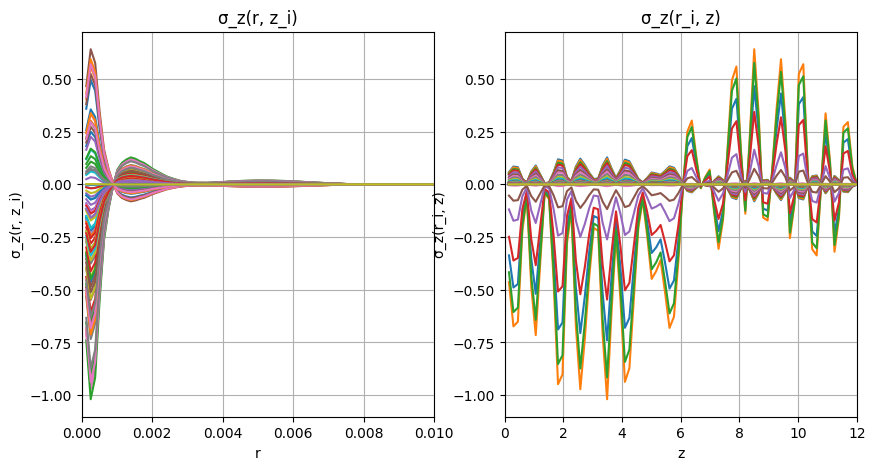

In [1321]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(sigma_z(r, i), 9), R, "r", "σ_z(r, z_i)", "σ_z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_z(i, z), 9), H, "z", "σ_z(r_i, z)", "σ_z(r_i, z)", plot=axis[1])

## Cylinder's visualization

In [1322]:
def draw_cylinder(colors=['red', 'blue', 'blue'] ,radius=1, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для боковой поверхности
    theta = np.linspace(0, 2 * np.pi, resolution)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z_bottom = np.zeros_like(x)
    z_top = np.ones_like(x) * height
    
    # Рисуем боковую поверхность
    for i in range(len(x) - 1):
        verts = [[(x[i], y[i], z_bottom[i]),
                  (x[i+1], y[i+1], z_bottom[i+1]),
                  (x[i+1], y[i+1], z_top[i+1]),
                  (x[i], y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color=colors[0], edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_bottom))], color=colors[1], edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_top))], color=colors[2], edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-radius, radius])
    ax.set_ylim([-radius, radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / radius])
    
    plt.show()

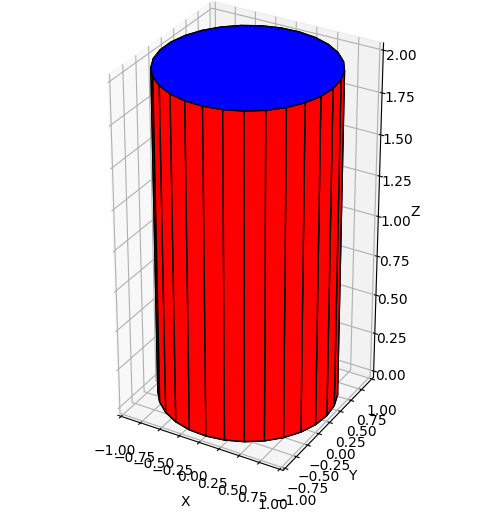

In [1323]:
draw_cylinder()

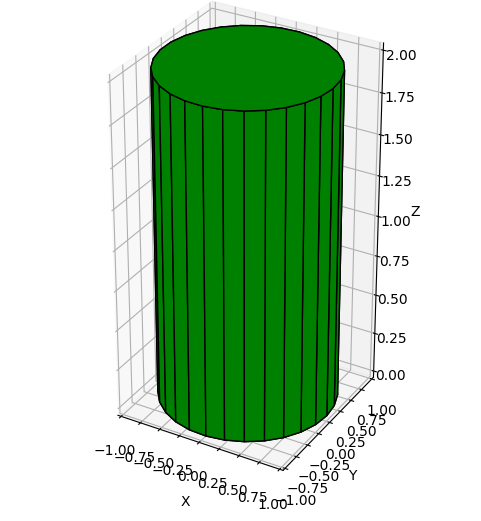

In [1324]:
draw_cylinder(['green', 'green', 'green'])

In [1325]:
def draw_pol_cylinder(outer_radius=1, inner_radius=0.7, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для внешней и внутренней боковых поверхностей
    theta = np.linspace(0, 2 * np.pi, resolution)
    outer_x = outer_radius * np.cos(theta)
    outer_y = outer_radius * np.sin(theta)
    inner_x = inner_radius * np.cos(theta)
    inner_y = inner_radius * np.sin(theta)
    z_bottom = np.zeros_like(outer_x)
    z_top = np.ones_like(outer_x) * height
    
    # Рисуем внешнюю боковую поверхность
    for i in range(len(outer_x) - 1):
        verts = [[(outer_x[i], outer_y[i], z_bottom[i]),
                  (outer_x[i+1], outer_y[i+1], z_bottom[i+1]),
                  (outer_x[i+1], outer_y[i+1], z_top[i+1]),
                  (outer_x[i], outer_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем внутреннюю боковую поверхность
    for i in range(len(inner_x) - 1):
        verts = [[(inner_x[i], inner_y[i], z_bottom[i]),
                  (inner_x[i+1], inner_y[i+1], z_bottom[i+1]),
                  (inner_x[i+1], inner_y[i+1], z_top[i+1]),
                  (inner_x[i], inner_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки как кольца
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_bottom)) + list(zip(inner_x[::-1], inner_y[::-1], z_bottom))], color='green', edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_top)) + list(zip(inner_x[::-1], inner_y[::-1], z_top))], color='green', edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-outer_radius, outer_radius])
    ax.set_ylim([-outer_radius, outer_radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / outer_radius])
    
    plt.show()


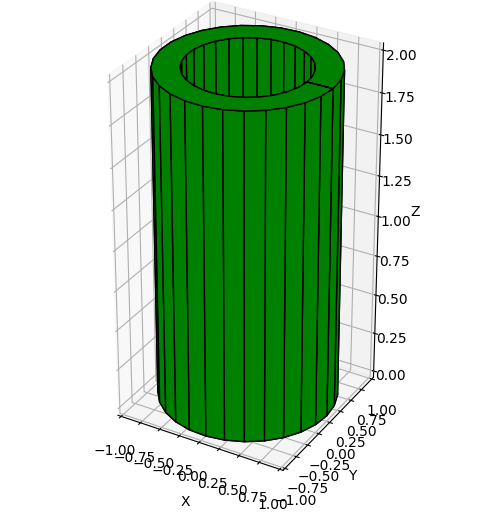

In [1326]:
draw_pol_cylinder()